In [7]:
from IPython.display import clear_output
import time
import numpy as np
import scipy as sc
import scipy.sparse as sp
import matplotlib.pyplot as plt
labelsize = 16

from scipy.optimize import minimize
from func.propagation import defmodel, extend_model
from func.inversion import second_order_derivative
from func.velocity_model import check_model, gaussian2d

precision = np.float32
device = 'cpu'

# Mapping function from u to v
def f(u, vmin=2000, vmax=3000):
    # CDF of gaussian
    cdf = sc.stats.norm.cdf(u.flatten(), loc=0, scale=1)
    v = (vmax-vmin) * cdf + vmin
    return v

def receiver_position(setup):
  
  if setup==1:
    # Setup 1
    zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1), receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
    zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]-1))) # Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==2:
    # Setup 2
    zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)//2, receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_width[:len(receivers_width)//2], np.full(nrec, zxsrc[0])[:len(receivers_width)//2])) # Half Left
    zxrec4 = np.vstack((receivers_width[:len(receivers_width)//2], np.full(nrec, nz-zxsrc[0]-1)[:len(receivers_width)//2])) # Half Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==3:
    # Setup 3
    zxrec1 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)//2, receivers_width)) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1), receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_width[len(receivers_width)//2:], np.full(nrec, zxsrc[0])[len(receivers_width)//2:])) # Half Left
    zxrec4 = np.vstack((receivers_width[len(receivers_width)//2:], np.full(nrec, nz-zxsrc[0]-1)[len(receivers_width)//2:])) # Half Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==4:
    # Setup 4
    zxrec1 = np.vstack((np.full(nrec, zxsrc[0])[:len(receivers_width)//2], receivers_width[:len(receivers_width)//2])) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)[:len(receivers_width)//2], receivers_width[:len(receivers_width)//2])) # Bottom
    zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
    zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]-1)//2)) # Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  zxrec = np.unique(zxrec,axis=1)

  return zxrec

In [95]:
def prop2d(wsrc, zxsrc, vel, at, az, ax, next, device='cpu'):
	"""
	2d wave propagation with multiple sources
	"""
	# wsrc = np.array([wsrc]) if wsrc.ndim == 1 else wsrc # convert source wavelet from 1d to 2d
	zxsrc = np.array(zxsrc)

	if device=='cpu':
		"""
		2d wave propagation
		Resolution with finite differences
		Orders 2 in time and space
		with absorbing boundaries (Clayton and Engquist)
		Vectorial implementation (much faster)
		"""
		nabs  = 10
		next2 = nabs + next
		nt    = len(at)
		nz    = len(az)
		nx    = len(ax)
		dz    = az[1] - az[0]
		dx    = ax[1] - ax[0]
		dt    = at[1] - at[0]   
		_dz2   = 1./dz**2
		_dx2   = 1./dx**2

		# Extend the model
		nze  = nz + 2*next2
		nxe  = nx + 2*next2
		vele = extend_model(vel,next2)

		# Shift the source by next
		extend_wsrc = np.zeros(nt)
		extend_wsrc[:len(wsrc)] = wsrc
		asrc = np.zeros([nze-2*nabs-2,nxe-2*nabs-2])
		pm    = np.zeros([nze,nxe], dtype=precision) # Previous wave field
		pp    = np.zeros([nze,nxe], dtype=precision)
		fact = (dt * vele[nabs:-nabs,nabs:-nabs])**2

		# Construct the sparse Laplacian matrix
		nze = nz + 2 * next2
		nxe = nx + 2 * next2

		# Calculate the size of the Laplacian matrix
		nzz, nxx = nz + 2*next, nx + 2*next
		size = nzz * nxx

		# Construct the Laplacian matrix
		diagonal = -2*np.ones(size)*(_dz2+_dx2)
		off_diagonal_x = np.ones(size - 1) * _dz2
		off_diagonal_z = np.ones(size - nxx) * _dx2

		# Set the off-diagonal elements of the Laplacian matrix for the x- and z-direction neighbors
		off_diagonal_x[nxx - 1::nxx] = 0
		off_diagonal_z[-nxx:] = 0

		# Create the Laplacian matrix L using the diagonal and off-diagonal values
		L = sp.diags([off_diagonal_x, off_diagonal_z, diagonal, off_diagonal_z, off_diagonal_x],
								[-1, -nxx, 0, nxx, 1], shape=(size, size))

		# Create the Transform matrix T using wave equation
		T = sp.diags(fact.flatten(), 0, format='csr').dot(L) + sp.diags(2*np.ones(size), 0, format='csr')

		d_obs = []
		p = [np.zeros((nz,nx))]

		for it in range(1,nt-1): # From 1 to nt-1
						pt = pp.copy()
						ptwsrc = np.zeros((nz,nx))
						ptwsrc[zxsrc[0,:], zxsrc[1,:]] = extend_wsrc[it]
						asrc[next:-next,next:-next] = ptwsrc[1:-1,1:-1]      # 0.0002s
						pp[1+nabs:-1-nabs,1+nabs:-1-nabs] = \
										T.dot(pt[nabs:-nabs, nabs:-nabs].flatten()).reshape(nzz, nxx)[1:-1, 1:-1] \
										- pm[1+nabs:-1-nabs,1+nabs:-1-nabs]\
										+ asrc * fact[1:-1, 1:-1]   
						pm = pt

						# One-way equation (bottom part)
						pp[nze-1-nabs:nze,:nxe] = pt[nze-1-nabs:nze,:nxe] - \
										vele[nze-1-nabs:nze,:nxe]*dt/dz* \
										(pt[nze-1-nabs:nze,:nxe]-pt[nze-2-nabs:nze-1,:nxe])
						# One-way equation (top part)
						pp[:1+nabs,:nxe] = pt[:1+nabs,:nxe] + \
										vele[:1+nabs,:nxe]*dt/dz* \
										(pt[1:2+nabs,:nxe]-pt[:1+nabs,:nxe])
						# One-way equation (right part)
						pp[:nze,nxe-1-nabs:nxe] = pt[:nze,nxe-1-nabs:nxe] - \
										vele[:nze,nxe-1-nabs:nxe]*dt/dx* \
						(pt[:nze,nxe-1-nabs:nxe] - pt[:nze,nxe-2-nabs:nxe-1])
						# One-way equation (left part)
						pp[:nze,:1+nabs] = pt[:nze,:1+nabs] + \
										vele[:nze,:1+nabs]*dt/dx* \
										(pt[:nze,1:2+nabs]-pt[:nze,:1+nabs])

						d_obs.append(pp[next2:nze-next2,next2:nxe-next2][zxrec[0], zxrec[1]])
						p.append(pp[next2:nze-next2,next2:nxe-next2].copy())

		d_obs = np.array(d_obs).T
		p.append(np.zeros((nz,nx)))
		p = np.moveaxis(np.array(p), 0, -1)

	return p, d_obs

def J(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device):
	nz, nx = len(az), len(ax)
	if vel.ndim == 1: vel = np.reshape(vel.flatten(),(nz,nx))
	_, d = prop2d(wsrc,zxsrc,vel,at,az,ax,next,device)
	residual = d - d_obs
	J = 0.5 * np.sum(residual ** 2) # Residual is the half of the L2 norm square

	return J

def gradiant(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device):
	"""
	Calculate gradiant using adjoint state method
	"""
	# Calculate forward propagated p_fwd(z,x,t) (to update)
	nz, nx, nt = len(az), len(ax), len(at)
	if vel.ndim == 1: vel = np.reshape(vel,(nz,nx))
	p_fwd, d = prop2d(wsrc,zxsrc,vel,at,az,ax,next,device)
	receiver_depth = zxrec[0]
	residual = d - d_obs # residual shape (n_rec, nt) - residual.shape=(5,801)
	# Calculate back propagated p_back(z,x,t)
	p_back = prop2d(np.flip(residual,axis=1), zxrec, vel, at, az, ax, next, device)
	p_back = np.flip(p_back,axis=2)
	# Calculate second order time derivative of p_fwd(z,x,t)
	p_dt_dt = second_order_derivative(p_fwd, at, az, ax)
	# Calculate gradiant
	G = 2/vel**3  * np.sum(p_back * p_dt_dt, axis=2) # G.shape = (201,201)

	return G.flatten()

In [97]:
gradiant(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)

ValueError: could not broadcast input array from shape (118,798) into shape (118,)

Min velocity: 2006.27  Max velocity 2998.51
dz,dx,dt (m): 8.0 8.0 0.001697056274847714
Model dimension [nz,nx,nt]:  200 200 800


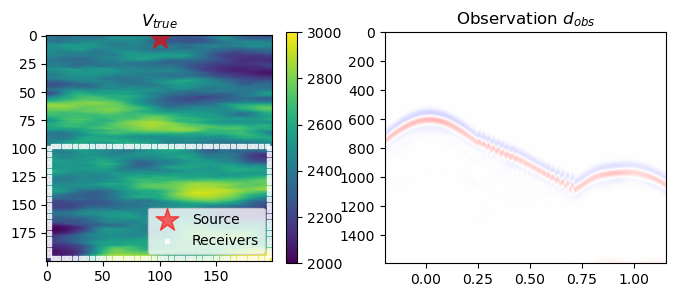

In [96]:
# Model size (nz,nx) = (200,200)

import pickle
# load data
filename = './data/u_200'
infile = open(filename, 'rb')
u_ref = pickle.load(infile)
infile.close()

filename = './data/Q_200'
infile = open(filename, 'rb')
Q = pickle.load(infile).astype('float32')
Q.astype('float32')
infile.close()

# Initialize the model axis az, ax, at
nz,nx,nt = 200,200,800
vmin,vmax = 2000,3000
izsrc, ixsrc = [nz//100], [nx//2]
next = 100

# u_ref, Q = gaussian2d(ranges = [100,20],param=1,nx=[nz,nx],variance=1,mean=0)
v_ref = f(u_ref)
print("Min velocity: %.2f " % v_ref.min()+" Max velocity %.2f" % v_ref.max())

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  
dz,dx,dt = az[1]-az[0],ax[1]-ax[0],at[1]-at[0]
# check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
interv = 5 # interval between receivers
receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
							np.arange(zxsrc[1][0],nx,interv)) #right
nrec = len(receivers_width)
zxrec = receiver_position(3)

_, d_obs = prop2d(wsrc,zxsrc,v_ref.reshape(nz,nx),at,az,ax,next,device)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1) 
plt.imshow(v_ref.reshape((nz,nx)),vmin=2000,vmax=3000)
plt.colorbar()
plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=5,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.title("$V_{true}$")
plt.subplot(1,2,2)
plt.imshow(d_obs.T,cmap='bwr',vmin=-10,vmax=10,extent=[at[0], at[-1], az[-1], az[0]], aspect='auto')
plt.title("Observation $d_{obs}$")
plt.show()

In [94]:
# minimize cost function
v_init = np.zeros([nz*nx]) + 2500   # Initial v
loss_tracker = np.empty((0,3))

std_noise = 0.1 # define the noise level
alpha = std_noise**2 # Regularization parameter/weight (Variance of observation noise)

resi = minimize(fun = J, 
               x0 = v_init, 
               args = (d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device),
               method='L-BFGS-B', 
               # method='Newton-CG',
            #    bounds = np.full((len(u_init.flatten()), 2), (vmin,vmax)),
               jac = gradiant,
               options = {'disp':True, 'maxiter':150},
              )
u_fwi = resi.x
print(u_fwi.shape)
print('Total time',time.strftime("%Hh %Mm %Ss", time.gmtime(time.time()-start)))

ValueError: could not broadcast input array from shape (118,798) into shape (118,)

## Reference code (Transformed)

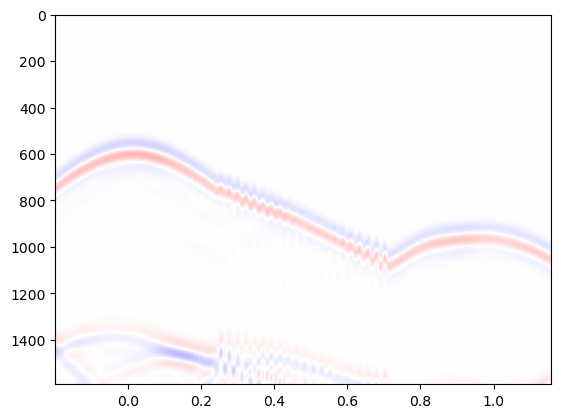

In [23]:
import numpy as np
import scipy.sparse as sp

vel = v_ref.reshape((nz,nx))
extend_wsrc = np.zeros(nt)
extend_wsrc[:len(wsrc)] = wsrc

next = 100
"""
2d wave propagation
Resolution with finite differences
Orders 2 in time and space
with absorbing boundaries (Clayton and Engquist)
Vectorial implementation (much faster)
"""
nabs  = 10
next2 = nabs + next
nt    = len(at)
nz    = len(az)
nx    = len(ax)
dz    = az[1] - az[0]
dx    = ax[1] - ax[0]
dt    = at[1] - at[0]   
_dz2   = 1./dz**2
_dx2   = 1./dx**2

# Extend the model
nze  = nz + 2*next2
nxe  = nx + 2*next2
vele = extend_model(vel,next2)

# Shift the source by next
asrc = np.zeros([nze-2*nabs-2,nxe-2*nabs-2])
# asrc[next:-next,next:-next,:] = pwsrc[1:-1,1:-1,:]
pm    = np.zeros([nze,nxe], dtype=precision) # Previous wave field
pp    = np.zeros([nze,nxe], dtype=precision)
fact = (dt * vele[nabs:-nabs,nabs:-nabs])**2

# Construct the sparse Laplacian matrix
nze = nz + 2 * next2
nxe = nx + 2 * next2

# Calculate the size of the Laplacian matrix
nzz, nxx = nz + 2*next, nx + 2*next
size = nzz * nxx

# Construct the Laplacian matrix
diagonal = -2*np.ones(size)*(_dz2+_dx2)
off_diagonal_x = np.ones(size - 1) * _dz2
off_diagonal_z = np.ones(size - nxx) * _dx2

# Set the off-diagonal elements of the Laplacian matrix for the x- and z-direction neighbors
off_diagonal_x[nxx - 1::nxx] = 0
off_diagonal_z[-nxx:] = 0

# Create the Laplacian matrix L using the diagonal and off-diagonal values
L = sp.diags([off_diagonal_x, off_diagonal_z, diagonal, off_diagonal_z, off_diagonal_x],
             [-1, -nxx, 0, nxx, 1], shape=(size, size))
# Create the Transform matrix T using wave equation
T = sp.diags(fact.flatten(), 0, format='csr').dot(L) + sp.diags(2*np.ones(size), 0, format='csr')
d_obs = []

for it in range(1,nt-1): # From 1 to nt-1
        pt = pp.copy()
        ptwsrc = np.zeros((nz,nx))
        ptwsrc[zxsrc[0,:], zxsrc[1,:]] = extend_wsrc[it]
        asrc[next:-next,next:-next] = ptwsrc[1:-1,1:-1]      # 0.0002s
        pp[1+nabs:-1-nabs,1+nabs:-1-nabs] = \
                T.dot(pt[nabs:-nabs, nabs:-nabs].flatten()).reshape(nzz, nxx)[1:-1, 1:-1] \
                - pm[1+nabs:-1-nabs,1+nabs:-1-nabs]\
                + asrc * fact[1:-1, 1:-1]   
        d_obs.append(pp[next2:nze-next2,next2:nxe-next2][zxrec[0], zxrec[1]])
        pm = pt

        # One-way equation (bottom part)
        pp[nze-1-nabs:nze,:nxe] = pt[nze-1-nabs:nze,:nxe] - \
                vele[nze-1-nabs:nze,:nxe]*dt/dz* \
                (pt[nze-1-nabs:nze,:nxe]-pt[nze-2-nabs:nze-1,:nxe])
        # One-way equation (top part)
        pp[:1+nabs,:nxe] = pt[:1+nabs,:nxe] + \
                vele[:1+nabs,:nxe]*dt/dz* \
                (pt[1:2+nabs,:nxe]-pt[:1+nabs,:nxe])
        # One-way equation (right part)
        pp[:nze,nxe-1-nabs:nxe] = pt[:nze,nxe-1-nabs:nxe] - \
                vele[:nze,nxe-1-nabs:nxe]*dt/dx* \
        (pt[:nze,nxe-1-nabs:nxe] - pt[:nze,nxe-2-nabs:nxe-1])
        # One-way equation (left part)
        pp[:nze,:1+nabs] = pt[:nze,:1+nabs] + \
                vele[:nze,:1+nabs]*dt/dx* \
                (pt[:nze,1:2+nabs]-pt[:nze,:1+nabs])

d_obs = np.array(d_obs).T
plt.imshow(d_obs.T,cmap='bwr',vmin=-10,vmax=10,extent=[at[0], at[-1], az[-1], az[0]], aspect='auto')

## Test code I

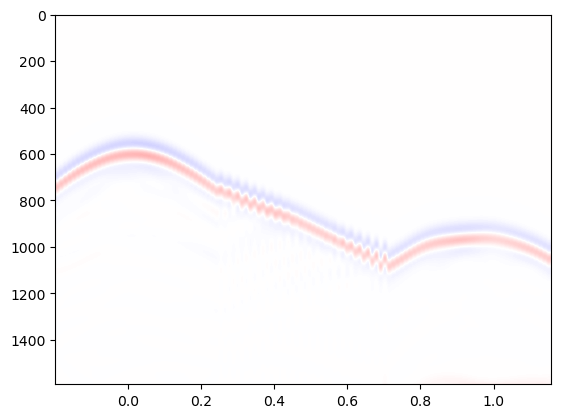

In [86]:
import numpy as np
import scipy.sparse as sp

vel = v_ref.reshape((nz,nx))
extend_wsrc = np.zeros(nt)
extend_wsrc[:len(wsrc)] = wsrc

next = 100
"""
2d wave propagation
Resolution with finite differences
Orders 2 in time and space
with absorbing boundaries (Clayton and Engquist)
Vectorial implementation (much faster)
"""
nabs  = 10
next2 = nabs + next
nt    = len(at)
nz    = len(az)
nx    = len(ax)
dz    = az[1] - az[0]
dx    = ax[1] - ax[0]
dt    = at[1] - at[0]   
_dz2   = 1./dz**2
_dx2   = 1./dx**2

# Extend the model
nze  = nz + 2*next2
nxe  = nx + 2*next2
vele = extend_model(vel,next2)

# Shift the source by next
asrc = np.zeros([nze-2*nabs-2,nxe-2*nabs-2])
# asrc[next:-next,next:-next,:] = pwsrc[1:-1,1:-1,:]
pm    = np.zeros([nze,nxe], dtype=precision) # Previous wave field
pp    = np.zeros([nze,nxe], dtype=precision)
fact = (dt * vele[nabs:-nabs,nabs:-nabs])**2

# Construct the sparse Laplacian matrix
nze = nz + 2 * next2
nxe = nx + 2 * next2

# Calculate the size of the Laplacian matrix
nzz, nxx = nz + 2*next, nx + 2*next
size = nzz * nxx

# Construct the Laplacian matrix
diagonal = -2*np.ones(size)*(_dz2+_dx2)
off_diagonal_x = np.ones(size - 1) * _dz2
off_diagonal_z = np.ones(size - nxx) * _dx2

# Set the off-diagonal elements of the Laplacian matrix for the x- and z-direction neighbors
off_diagonal_x[nxx - 1::nxx] = 0
off_diagonal_z[-nxx:] = 0

# Create the Laplacian matrix L using the diagonal and off-diagonal values
L = sp.diags([off_diagonal_x, off_diagonal_z, diagonal, off_diagonal_z, off_diagonal_x],
             [-1, -nxx, 0, nxx, 1], shape=(size, size))
# Create the Transform matrix T using wave equation
T = sp.diags(fact.flatten(), 0, format='csr').dot(L) + sp.diags(2*np.ones(size), 0, format='csr')

d_obs = []
p = [np.zeros((nz,nx))]

for it in range(1,nt-1): # From 1 to nt-1
        pt = pp.copy()
        ptwsrc = np.zeros((nz,nx))
        ptwsrc[zxsrc[0,:], zxsrc[1,:]] = extend_wsrc[it]
        asrc[next:-next,next:-next] = ptwsrc[1:-1,1:-1]      # 0.0002s
        pp[1+nabs:-1-nabs,1+nabs:-1-nabs] = \
                T.dot(pt[nabs:-nabs, nabs:-nabs].flatten()).reshape(nzz, nxx)[1:-1, 1:-1] \
                - pm[1+nabs:-1-nabs,1+nabs:-1-nabs]\
                + asrc * fact[1:-1, 1:-1]   
        pm = pt

        # One-way equation (bottom part)
        pp[nze-1-nabs:nze,:nxe] = pt[nze-1-nabs:nze,:nxe] - \
                vele[nze-1-nabs:nze,:nxe]*dt/dz* \
                (pt[nze-1-nabs:nze,:nxe]-pt[nze-2-nabs:nze-1,:nxe])
        # One-way equation (top part)
        pp[:1+nabs,:nxe] = pt[:1+nabs,:nxe] + \
                vele[:1+nabs,:nxe]*dt/dz* \
                (pt[1:2+nabs,:nxe]-pt[:1+nabs,:nxe])
        # One-way equation (right part)
        pp[:nze,nxe-1-nabs:nxe] = pt[:nze,nxe-1-nabs:nxe] - \
                vele[:nze,nxe-1-nabs:nxe]*dt/dx* \
        (pt[:nze,nxe-1-nabs:nxe] - pt[:nze,nxe-2-nabs:nxe-1])
        # One-way equation (left part)
        pp[:nze,:1+nabs] = pt[:nze,:1+nabs] + \
                vele[:nze,:1+nabs]*dt/dx* \
                (pt[:nze,1:2+nabs]-pt[:nze,:1+nabs])

        d_obs.append(pp[next2:nze-next2,next2:nxe-next2][zxrec[0], zxrec[1]])
        p.append(pp[next2:nze-next2,next2:nxe-next2].copy())

d_obs = np.array(d_obs).T
p.append(np.zeros((nz,nx)))
p = np.moveaxis(np.array(p), 0, -1)
plt.imshow(d_obs.T,cmap='bwr',vmin=-10,vmax=10,extent=[at[0], at[-1], az[-1], az[0]], aspect='auto')